In [1]:
import os
import sys
import csv
sys.path.insert(0, os.path.abspath('../'))

import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D as ax
import arrayfire as af

from dg_maxwell import params
from dg_maxwell import utils
from dg_maxwell import lagrange
from dg_maxwell import wave_equation_2d as w2d
from dg_maxwell import msh_parser
from dg_maxwell import isoparam

af.set_backend(params.backend)
af.set_device(params.device)

gmshtranslator friendly reminder: rules and actions prototypes


def node_condition(tag,x,y,z,physgroups): 
def node_action(tag,x,y,z):
def element_condition(eletag,eletype,physgrp,nodes):
def element_action(eletag,eletype,physgrp,nodes):


/home/bala/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1187: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/bala/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1214: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


In [2]:
nodes, elements = msh_parser.read_order_2_msh('read_and_plot_mesh/mesh/square_10_10.msh')

gmshTranslator: Initializing...
gmshTranslator: Mesh has 441 nodes.
gmshTranslator: Mesh has 144 elements.
gmshTranslator: Processed 589 lines.
gmshTranslator: There are 1 physical groups available: 
gmshTranslator:      > 0
gmshTranslator: Parsing nodes
gmshTranslator: Parsing elements
gmshTranslator: No rules for elements... skipping elements.
gmshTranslator: Parsing nodes
gmshTranslator: No rules for nodes... skipping nodes.
gmshTranslator: Parsing elements


In [3]:
def u_init(x, y):
    return np.e**(-(x**2 + y**2) / 0.4**2)

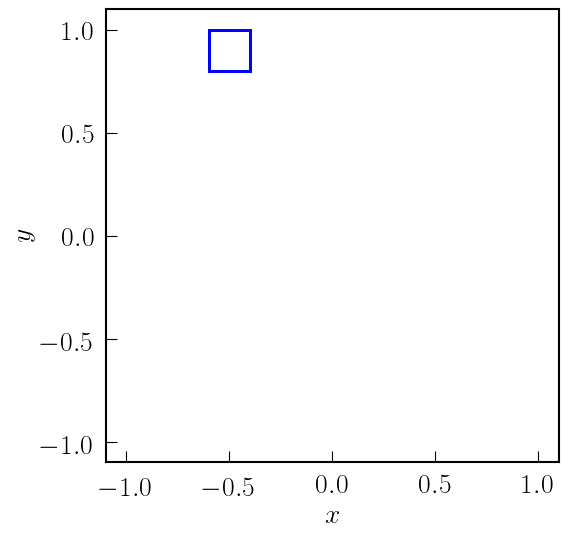

In [13]:
axes_handler = plt.axes()

# for element_id in np.arange(10, 20):
element_id = 2
msh_parser.plot_element_boundary(nodes[elements[element_id], 0],
                                 nodes[elements[element_id], 1],
                                 axes_handler)

plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.axes().set_aspect('equal')
# plt.savefig('square.png')
plt.show()


In [5]:
N_LGL   = 8
x_e_ij  = af.np_to_af_array(np.zeros([N_LGL * N_LGL, len(elements)]))
y_e_ij  = af.np_to_af_array(np.zeros([N_LGL * N_LGL, len(elements)]))

xi_LGL  = lagrange.LGL_points(N_LGL)
eta_LGL = lagrange.LGL_points(N_LGL)

Xi_LGL, Eta_LGL = utils.af_meshgrid(xi_LGL, eta_LGL)
xi_i  = af.flat(Xi_LGL)
eta_j = af.flat(Eta_LGL)

for element_tag, element in enumerate(elements):
    x_e_ij[:, element_tag] = isoparam.isoparam_x_2D(nodes[element, 0], xi_i, eta_j)
    y_e_ij[:, element_tag] = isoparam.isoparam_y_2D(nodes[element, 1], xi_i, eta_j)


/home/bala/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1187: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/bala/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1214: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


In [6]:
u_e_ij = u_init(x_e_ij, y_e_ij)

In [7]:
dxi_dx  = af.constant(0, N_LGL**2, len(elements), dtype = af.Dtype.f64)
dxi_dy  = af.constant(0, N_LGL**2, len(elements), dtype = af.Dtype.f64)
deta_dx = af.constant(0, N_LGL**2, len(elements), dtype = af.Dtype.f64)
deta_dy = af.constant(0, N_LGL**2, len(elements), dtype = af.Dtype.f64)

for element_tag, element in enumerate(elements):
    dxi_dx[:, element_tag]  = w2d.dxi_dx(nodes[element][:, 0], nodes[element][:, 1], xi_i, eta_j)
    dxi_dy[:, element_tag]  = w2d.dxi_dy(nodes[element][:, 0], nodes[element][:, 1], xi_i, eta_j)
    deta_dx[:, element_tag] = w2d.deta_dx(nodes[element][:, 0], nodes[element][:, 1], xi_i, eta_j)
    deta_dy[:, element_tag] = w2d.deta_dy(nodes[element][:, 0], nodes[element][:, 1], xi_i, eta_j)

In [8]:
def F_xi(u, dxi_dx, dxi_dy):
    '''
    '''
    F_xi_u = w2d.F_x(u) * dxi_dx + w2d.F_y(u) * dxi_dy

    return F_xi_u

def F_eta(u, deta_dx, deta_dy):
    '''
    '''
    F_eta_u = w2d.F_x(u) * deta_dx + w2d.F_y(u) * deta_dy
    
    return F_eta_u

In [9]:
def g_dd(x_nodes, y_nodes, xi, eta):
    '''
    '''
    ans00  =   (w2d.dx_dxi(x_nodes, xi, eta))**2 \
             + (w2d.dy_dxi(y_nodes, xi, eta))**2
    ans11  =   (w2d.dx_deta(x_nodes, xi, eta))**2 \
             + (w2d.dy_deta(y_nodes, xi, eta))**2
    
    ans01  =  (w2d.dx_dxi(x_nodes, xi, eta))  \
            * (w2d.dx_deta(x_nodes, xi, eta)) \
            + (w2d.dy_dxi(y_nodes, xi, eta))  \
            * (w2d.dy_deta(y_nodes, xi, eta))
    
    ans =  [[ans00, ans01],
            [ans01, ans11]
           ]
    
    return ans


def g_uu(x_nodes, y_nodes, xi, eta):
    gCov = g_dd(x_nodes, y_nodes, xi, eta)
    
    
    a = gCov[0][0]
    b = gCov[0][1]
    c = gCov[1][0]
    d = gCov[1][1]
    
    det = (a*d - b*c)
    
    ans = [[d / det, -b / det],
           [-c / det, a / det]]
    
    return ans

In [10]:
G_ab = [[af.constant(0, N_LGL * N_LGL, len(elements), dtype = af.Dtype.f64),
         af.constant(0, N_LGL * N_LGL, len(elements), dtype = af.Dtype.f64)],
        [af.constant(0, N_LGL * N_LGL, len(elements), dtype = af.Dtype.f64),
         af.constant(0, N_LGL * N_LGL, len(elements), dtype = af.Dtype.f64)]]

for element_tag, element in enumerate(elements):
    g_ab = g_uu(nodes[element][:, 0], nodes[element][:, 1], xi_i, eta_j)
    G_ab[0][0][:, element_tag] = g_ab[0][0]
    G_ab[0][1][:, element_tag] = g_ab[0][1]
    G_ab[1][0][:, element_tag] = g_ab[1][0]
    G_ab[1][1][:, element_tag] = g_ab[1][1]

In [11]:
f_xi  = F_xi(u_e_ij, dxi_dx, deta_dy)
f_eta = F_eta(u_e_ij, deta_dx, deta_dy)

In [25]:
af.shift?

In [62]:
def lax_friedrichs_flux(u):
    '''
    '''
    params.N_LGL = 8
    u = af.reorder(af.moddims(u, params.N_LGL ** 2, 10, 10), 2, 1, 0)

    diff_u_boundary = af.np_to_af_array(np.zeros([10, 10, params.N_LGL ** 2]))

    u_xi_minus1_boundary_right   = u[:, :, :params.N_LGL]
    u_xi_minus1_boundary_left    = af.shift(u[:, :, -params.N_LGL:], d0=0, d1 = 1)
    u[:, :, :params.N_LGL] = (u_xi_minus1_boundary_right + u_xi_minus1_boundary_left) / 2
    
    diff_u_boundary[:, :, :params.N_LGL] = (u_xi_minus1_boundary_right - u_xi_minus1_boundary_left)

    u_xi_1_boundary_left  = u[:, :, -params.N_LGL:]
    u_xi_1_boundary_right = af.shift(u[:, :, :params.N_LGL], d0=0, d1=-1)
    u[:, :, :params.N_LGL]     = (u_xi_minus1_boundary_left + u_xi_minus1_boundary_right) / 2
    
    diff_u_boundary[:, :, -params.N_LGL:] = (u_xi_minus1_boundary_left - u_xi_minus1_boundary_right)

    u_eta_1_boundary_down = u[:, :, params.N_LGL - 1:params.N_LGL ** 2:params.N_LGL]
    u_eta_1_boundary_up   = af.shift(u[:, :, 0:-params.N_LGL + 1:params.N_LGL], d0=1)
    
    u[:, :, params.N_LGL - 1:params.N_LGL ** 2:params.N_LGL] = (u_eta_1_boundary_up\
                                                              +u_eta_1_boundary_down) / 2

    diff_u_boundary[:, :, params.N_LGL - 1:params.N_LGL ** 2:params.N_LGL] = (u_eta_1_boundary_up\
                                                                             -u_eta_1_boundary_down)


    u_eta_minus1_boundary_down = af.shift(u[:, :, params.N_LGL - 1:params.N_LGL ** 2:params.N_LGL], d0=-1)
    u_eta_minus1_boundary_up   = u[:, :, 0:-params.N_LGL + 1:params.N_LGL]
    u[:, :, 0:-params.N_LGL + 1:params.N_LGL] = (u_eta_minus1_boundary_down\
                                               + u_eta_minus1_boundary_up) / 2

    diff_u_boundary[:, :, 0:-params.N_LGL + 1:params.N_LGL] = (u_eta_minus1_boundary_down\
                                                             - u_eta_minus1_boundary_up)


    u = af.moddims(af.reorder(u, 2, 1, 0), params.N_LGL ** 2, 100)
    diff_u_boundary = af.moddims(af.reorder(diff_u_boundary, 2, 1, 0), params.N_LGL ** 2, 100)
    F_xi_e_ij  = F_xi(u, dxi_dx, deta_dy) - params.c_lax * diff_u_boundary
    F_eta_e_ij = F_eta(u, deta_dx, deta_dy) - params.c_lax * diff_u_boundary

    return F_xi_e_ij, F_eta_e_ij

3.9170056087556304e-15
